In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import configparser
import os.path
from os import path
from importlib import reload
import wandb


creds_path_ar = ["../../credentials.ini","credentials.colab.ini"]
PATH_ROOT = ""
PATH_DATA = ""

for creds_path in creds_path_ar:
    if path.exists(creds_path):
        config_parser = configparser.ConfigParser()
        config_parser.read(creds_path)
        PATH_ROOT = config_parser['MAIN']["PATH_ROOT"]
        PATH_DATA = config_parser['MAIN']["PATH_DATA"]
        WANDB_enable = config_parser['MAIN']["WANDB_ENABLE"] == 'TRUE'
        ENV = config_parser['MAIN']["ENV"]
        break

if ENV=="COLAB":
  from google.colab import drive
  mount_path = '/content/gdrive/'
  drive.mount(mount_path)



In [3]:
if WANDB_enable == True:
    wandb.init(project="sota-mafat-base")
    os.environ['WANDB_NOTEBOOK_NAME'] = '[SS]TCN_pytorch'

In [4]:
cd {PATH_ROOT}

/home/shaul/workspace/GitHub/sota-mafat-radar


In [5]:
import os
import random
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim


from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score
from matplotlib.colors import LinearSegmentedColormap
from termcolor import colored

from src.data import feat_data, get_data
from src.models import arch_setup, base_base_model, alex_model, tcn_model

# Set seed for reproducibility of results
seed_value = 0
os.environ['PYTHONHASHSEED']=str(seed_value)


random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu:0')

In [220]:
config = dict()
config['num_tracks'] = 4
config['val_ratio'] = 6
config['shift_segment'] = np.arange(1,32)
config['get_shifts'] = True
config['get_horizontal_flip'] = False
config['get_vertical_flip'] = False

In [221]:
train_x, train_y, val_x, val_y = get_data.classic_trainval(PATH_ROOT+PATH_DATA)

Everything is setup correctly


In [227]:
train_set = arch_setup.DS(train_x.squeeze(),train_y)
val_set= arch_setup.DS(val_x.squeeze(),val_y)

train_loader=DataLoader(dataset= train_set, batch_size = 32, shuffle = True, num_workers = 2)
val_loader=DataLoader(dataset= val_set, batch_size = 32, shuffle = True, num_workers = 2)

In [234]:
model = tcn_model.TCNModel(num_channels=[64]*6, kernel_size=5, dropout=0.2)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), betas=(0.9, 0.999), lr=1e-3, weight_decay=0)

model.to(device)

if WANDB_enable == True:
    wandb.init(project="sota-mafat-base")
    os.environ['WANDB_NOTEBOOK_NAME'] = '[SS]TCN_pytorch'
    wandb.watch(model)
    wandb.log(config)
    wandb.config['num_channels'] = "[64]*6"
    wandb.config['kernel_size'] = 5
    wandb.config['dropout'] = 0.2

In [235]:
log = arch_setup.train_epochs(train_loader,val_loader,model,criterion,optimizer,num_epochs= 20,device=device,train_y=train_y,val_y=val_y, WANDB_enable = WANDB_enable, wandb= wandb)

started training epoch no. 1
epoch : 1.0000, loss : 51.6079, auc : 0.9138, acc : 0.8914, val_loss : 5.6489, val_auc : 0.7922, val_acc : 0.7314, 
---------------------------

started training epoch no. 2
epoch : 2.0000, loss : 42.7196, auc : 0.9430, acc : 0.9163, val_loss : 6.3883, val_auc : 0.8076, val_acc : 0.7152, 
---------------------------

started training epoch no. 3
epoch : 3.0000, loss : 38.0177, auc : 0.9556, acc : 0.9257, val_loss : 7.5680, val_auc : 0.7901, val_acc : 0.6667, 
---------------------------

started training epoch no. 4
epoch : 4.0000, loss : 34.0080, auc : 0.9651, acc : 0.9332, val_loss : 5.4371, val_auc : 0.8416, val_acc : 0.7476, 
---------------------------

started training epoch no. 5
epoch : 5.0000, loss : 28.8863, auc : 0.9758, acc : 0.9444, val_loss : 5.3693, val_auc : 0.8373, val_acc : 0.7638, 
---------------------------

started training epoch no. 6
epoch : 6.0000, loss : 25.0842, auc : 0.9818, acc : 0.9501, val_loss : 5.0116, val_auc : 0.8620, val_

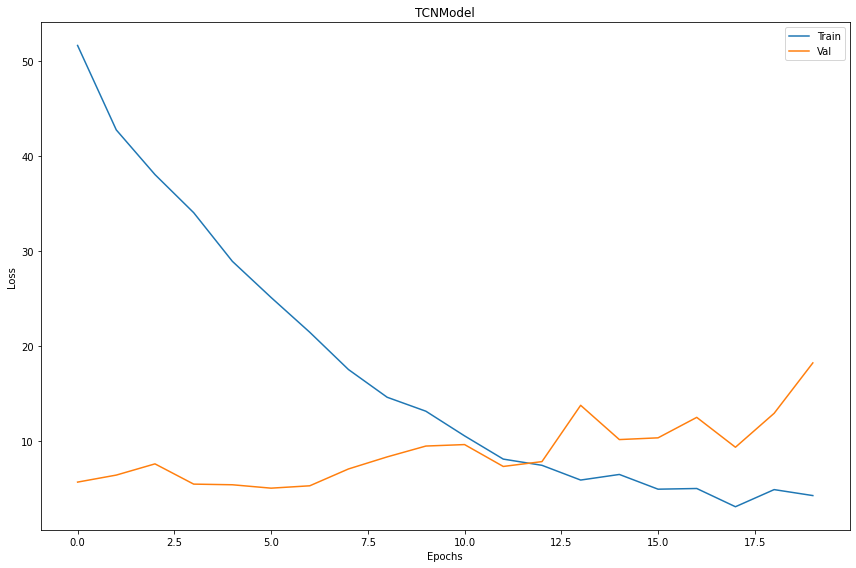

In [236]:
arch_setup.plot_loss_train_test(log,model)

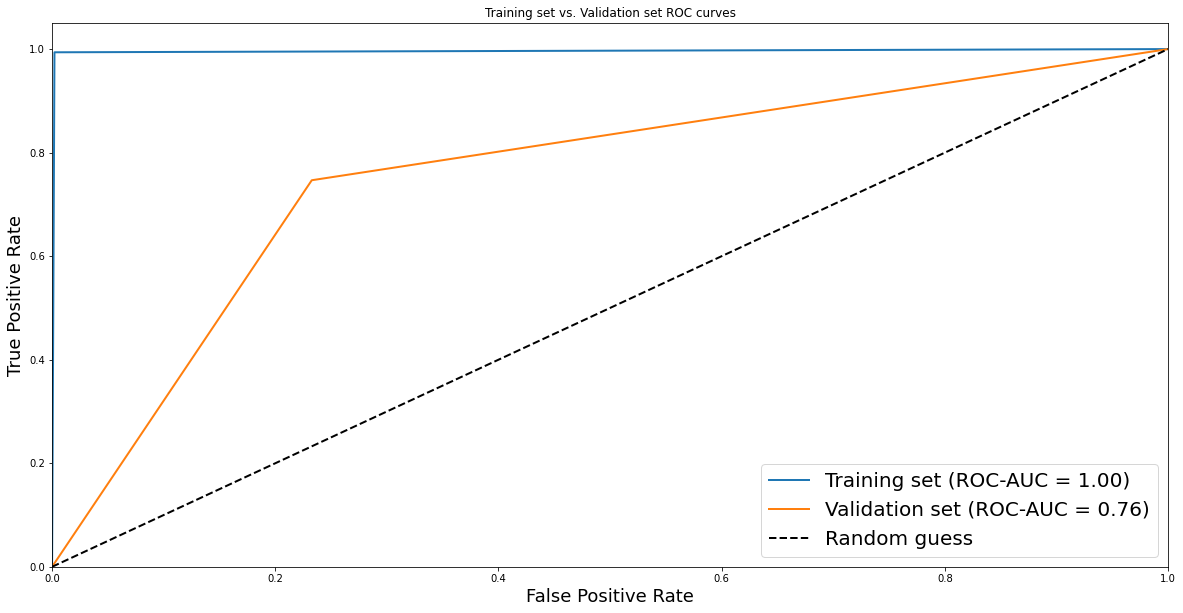

In [237]:
arch_setup.plot_ROC_local_gpu(train_loader,val_loader,model,device)

In [242]:
from src.features import specto_feat

In [243]:
test_path = 'MAFAT RADAR Challenge - Public Test Set V1'
test_df = get_data.load_data(PATH_ROOT+PATH_DATA+test_path)
test_df = specto_feat.data_preprocess(test_df.copy())
test_x = test_df['iq_sweep_burst']
test_x = test_x.reshape(list(test_x.shape)+[1])

In [250]:
# Creating DataFrame with the probability prediction for each segment
submission =  pd.DataFrame()
submission['segment_id'] = test_df['segment_id']
submission['prediction'] = model(torch.from_numpy(test_x.squeeze()).type(torch.FloatTensor)).detach().numpy()
submission['prediction'] = submission['prediction'].astype('float')

# Save submission
submission.to_csv('submission.csv', index=False)